##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 簡単な音声認識: キーワードの認識

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio"> <img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/audio/simple_audio.ipynb"> <img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/audio/simple_audio.ipynb"> <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、WAV 形式の音声ファイルを前処理し、基本的な<a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">自動音声認識</a> (ASR) モデルを構築およびトレーニングして 10 の異なる単語を認識させる方法を示します。[Speech Commands データセット](https://www.tensorflow.org/datasets/catalog/speech_commands) (<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>) の一部を使用します。これには、「down」、「go」、「left」、「no」、「right」、「stop」、「up」、「yes」などのコマンドの短い (1 秒以下) 音声クリップが含まれています。

現実世界の音声認識<a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">システム</a>は複雑ですが、[MNIST データセットを使用した画像分類](../quickstart/beginner.ipynb)と同様に、このチュートリアルでは、関連する基本的な手法について説明します。

## セットアップ

必要なモジュールと依存関係をインポートします。ここでは、`.wav` ファイルから音声分類データセットを生成する際に役立つ `tf.keras.utils.audio_dataset_from_directory`（TensorFlow 2.10 で導入）を使用します。このチュートリアルでは、可視化を行うための [seaborn](https://seaborn.pydata.org) も必要です。

In [2]:
!pip install -U -q tensorflow tensorflow_datasets

In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-01-11 22:07:31.258054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:07:31.258099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:07:31.259707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Mini  Speech Commands データセットをインポートする

データの読み込みにかかる時間を短縮するために、Speech Commands データセットの小さいバージョンを使用します。[元のデータセット](https://www.tensorflow.org/datasets/catalog/speech_commands)には、105,000 を超える <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (波形) ファイル形式</a>の音声ファイルが含まれており、様々な人が 35 個の英単語を発音しています。このデータは Google によって収集され、CC BY ライセンスの下で公開されました。

`tf.keras.utils.get_file` を使用して、小さな音声コマンドデータセットを含む `mini_speech_commands.zip` ファイルをダウンロードして解凍します。

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

     8192/182082353 [..............................] - ETA: 0s

  5767168/182082353 [..............................] - ETA: 1s

  8396800/182082353 [>.............................] - ETA: 2s

 23592960/182082353 [==>...........................] - ETA: 1s

 31383552/182082353 [====>.........................] - ETA: 1s

 41435136/182082353 [=====>........................] - ETA: 0s

 56492032/182082353 [========>.....................] - ETA: 0s

 66289664/182082353 [=========>....................] - ETA: 0s

 72630272/182082353 [==========>...................] - ETA: 0s

 82673664/182082353 [============>.................] - ETA: 0s

101187584/182082353 [===============>..............] - ETA: 0s

114892800/182082353 [=================>............] - ETA: 0s

124280832/182082353 [===================>..........] - ETA: 0s

130957312/182082353 [====================>.........] - ETA: 0s

145547264/182082353 [======================>.......] - ETA: 0s

158834688/182082353 [=========================>....] - ETA: 0s

173129728/182082353 [===========================>..] - ETA: 0s

182082353/182082353 [==============================] - 1s 0us/step


データセットの音声クリップは、各音声コマンド (`no`、`yes`、`down`、`go`、`left`、`up`、`right`、`stop`) に対応する 8 つのフォルダに保存されています。

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'stop' 'right' 'yes' 'up' 'go' 'left' 'no']


このようにディレクトリに分割すると、`keras.utils.audio_dataset_from_directory` を使用してデータを簡単に読み込めます。

音声クリップは 16kHz で 1 秒以下です。 `output_sequence_length=16000` は、簡単にバッチ処理できるように、短いものを正確に 1 秒にパディングします (長いものはトリミングします)。

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.


Using 6400 files for training.


Using 1600 files for validation.



label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


データセットには、音声クリップと整数ラベルのバッチが含まれるようになりました。音声クリップの形状は `(batch, samples, channels)` です。 

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

このデータセットには単一チャンネルの音声しか含まれていないため、`tf.squeeze` 関数を使用して余分な軸を削除します。

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

`utils.audio_dataset_from_directory` 関数は、最大 2 つの分割のみを返します。テストセットを検証セットとは別にしておくことをお勧めします。別のディレクトリに保存するのが理想的ですが、この場合は `Dataset.shard` を使用して検証セットを 2 つに分割できます。**任意の**シャードを反復処理すると、**すべて**のデータが読み込まれ、その一部のみが保持されることに注意してください。 

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


いくつかの音声波形をプロットします。

In [11]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

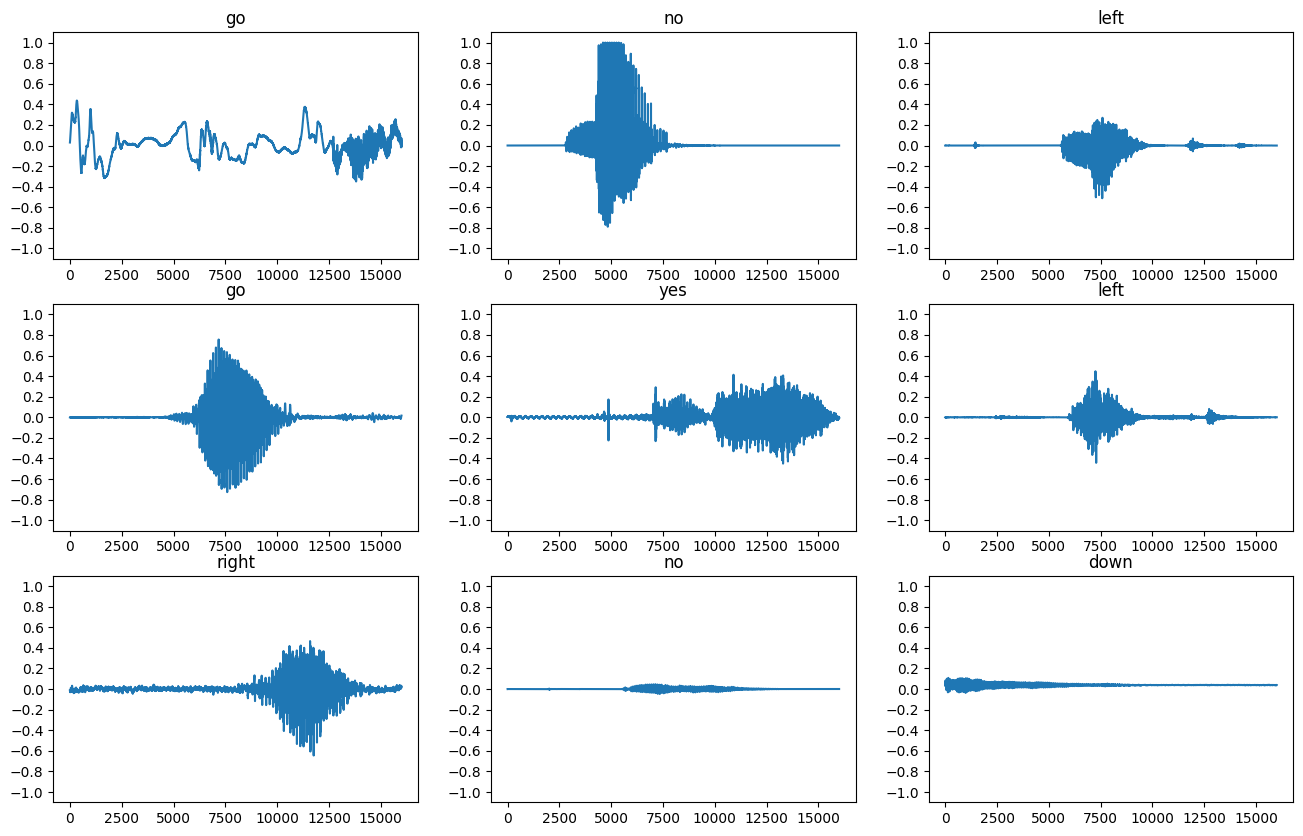

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## 波形をスペクトログラムに変換

データセットの波形は時間ドメインで表されます。次に、<a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">短時間フーリエ変換 (STFT)</a> を計算して波形を<a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">スペクトログラム</a>に変換することにより、波形を時間ドメイン信号から時間周波数ドメイン信号に変換します。時間の経過に伴う周波の変化を示し、2D 画像として表すことができます。スペクトログラム画像をニューラル ネットワークにフィードして、モデルをトレーニングします。

フーリエ変換 (`tf.signal.fft`) は、信号をその成分の周波数に変換しますが、すべての時間情報は失われます。対照的に、STFT (`tf.signal.stft`) は信号を時間のウィンドウに分割し、時間情報を保持して各ウィンドウでフーリエ変換を実行し、2D テンソルを返すので標準の畳み込みを実行できます。

波形をスペクトログラムに変換するユーティリティ関数を作成します。

- 波形をスペクトログラムに変換する場合、結果が同様の次元になるように、波形は同じ長さである必要があります。そのために、1 秒未満の音声クリップはゼロパディングします (`tf.zeros` を使用)。
- `tf.signal.stft` を呼び出すときは、生成されたスペクトログラム「画像」がほぼ正方形になるように `frame_length` および `frame_step` パラメータを選択します。STFT パラメータの選択の詳細については、音声信号処理と STFT に関する<a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">この Coursera 動画</a>を参照してください。
- STFT は、大きさと位相を表す複素数の配列を生成します。ただし、このチュートリアルでは、`tf.signal.stft` の出力に `tf.abs` を適用することで導出できる大きさのみを使用します。

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

次に、データを探索します。1 つの例のテンソル化された波形と対応するスペクトログラムの形状を出力し、元の音声を再生します。

In [14]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


次に、スペクトログラムを表示する関数を定義します。

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

時間の経過に伴う例の波形と、対応するスペクトログラム (時間の経過に伴う周波数) をプロットします。

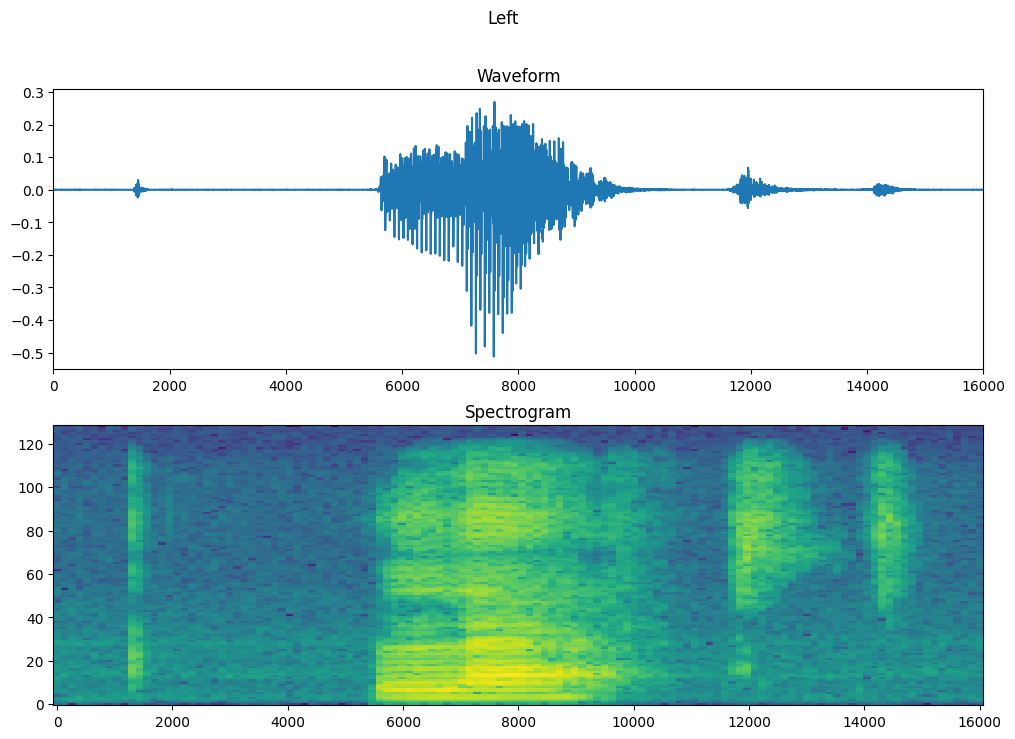

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

音声データセットからスペクトログラムデータセットを作成します。

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

データセットのさまざまな例のスペクトログラムを調べます。

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

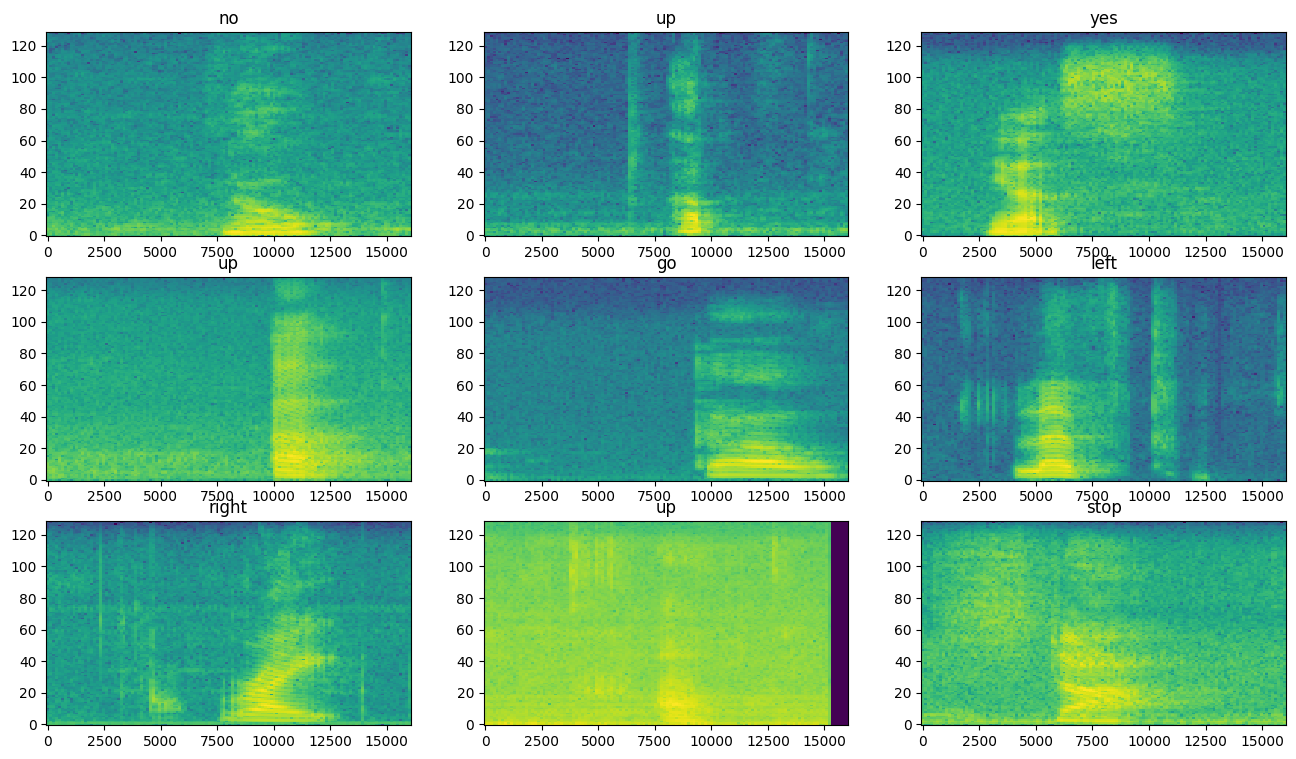

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## モデルを構築してトレーニングする

`Dataset.cache` と `Dataset.prefetch` 演算を追加して、モデルのトレーニング時の読み取りレイテンシを短縮します。

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

音声ファイルをスペクトログラム画像に変換したので、モデルで単純な畳み込みニューラル ネットワーク (CNN) を使用します。

`tf.keras.Sequential` モデルは、次の Keras 前処理レイヤーを使用します。

- `tf.keras.layers.Resizing` は入力をダウンサンプリングし、モデルをより迅速にトレーニングできるようにします。
- `tf.keras.layers.Normalization` は平均値と標準偏差に基づいて画像内の各ピクセルを正規化します。

`Normalization` レイヤーの場合、まずトレーニングデータに対して `adapt` メソッドを呼び出して、集計統計 (平均と標準偏差) を計算する必要があります。

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resizing (Resizing)         (None, 32, 32, 1)         0         


 normalization (Normalizati  (None, 32, 32, 1)         3         


 on)                                                             


 conv2d (Conv2D)             (None, 30, 30, 32)        320       


 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     


 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         


 D)                                                              


 dropout (Dropout)           (None, 14, 14, 64)        0         


 flatten (Flatten)           (None, 12544)             0         


 dense (Dense)               (None, 128)               1605760   


 dropout_1 (Dropout)         (None, 128)               0         


 dense_1 (Dense)             (None, 8)                 1032      


Total params: 1625611 (6.20 MB)


Trainable params: 1625608 (6.20 MB)


Non-trainable params: 3 (16.00 Byte)


_________________________________________________________________


Adam オプティマイザとクロスエントロピー損失を使用して Keras モデルを構成します。

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

デモするために、モデルを 10 エポックにわたってトレーニングします。

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2024-01-11 22:07:47.222482: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1705010869.111571 1000761 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/100 [..............................] - ETA: 6:05 - loss: 2.1252 - accuracy: 0.1094

  8/100 [=>............................] - ETA: 0s - loss: 2.1396 - accuracy: 0.1582  

 15/100 [===>..........................] - ETA: 0s - loss: 2.0881 - accuracy: 0.1854

 22/100 [=====>........................] - ETA: 0s - loss: 2.0547 - accuracy: 0.2166

 29/100 [=======>......................] - ETA: 0s - loss: 2.0188 - accuracy: 0.2441

 36/100 [=========>....................] - ETA: 0s - loss: 1.9800 - accuracy: 0.2569

 43/100 [===========>..................] - ETA: 0s - loss: 1.9463 - accuracy: 0.2725

 50/100 [==============>...............] - ETA: 0s - loss: 1.9200 - accuracy: 0.2841

 57/100 [================>.............] - ETA: 0s - loss: 1.8961 - accuracy: 0.2974

 64/100 [==================>...........] - ETA: 0s - loss: 1.8749 - accuracy: 0.3062

 71/100 [====================>.........] - ETA: 0s - loss: 1.8557 - accuracy: 0.3180

 78/100 [======================>.......] - ETA: 0s - loss: 1.8333 - accuracy: 0.3249

 85/100 [========================>.....] - ETA: 0s - loss: 1.8115 - accuracy: 0.3340

 92/100 [==========================>...] - ETA: 0s - loss: 1.7958 - accuracy: 0.3451

 99/100 [============================>.] - ETA: 0s - loss: 1.7784 - accuracy: 0.3531

100/100 [==============================] - 5s 12ms/step - loss: 1.7746 - accuracy: 0.3548 - val_loss: 1.3972 - val_accuracy: 0.5586


Epoch 2/10


  1/100 [..............................] - ETA: 0s - loss: 1.6045 - accuracy: 0.4219

  8/100 [=>............................] - ETA: 0s - loss: 1.4320 - accuracy: 0.5059

 15/100 [===>..........................] - ETA: 0s - loss: 1.4123 - accuracy: 0.5104

 22/100 [=====>........................] - ETA: 0s - loss: 1.3850 - accuracy: 0.5178

 29/100 [=======>......................] - ETA: 0s - loss: 1.3730 - accuracy: 0.5334

 36/100 [=========>....................] - ETA: 0s - loss: 1.3460 - accuracy: 0.5430

 43/100 [===========>..................] - ETA: 0s - loss: 1.3304 - accuracy: 0.5400

 50/100 [==============>...............] - ETA: 0s - loss: 1.3225 - accuracy: 0.5431

 57/100 [================>.............] - ETA: 0s - loss: 1.3124 - accuracy: 0.5474

 64/100 [==================>...........] - ETA: 0s - loss: 1.3047 - accuracy: 0.5466

 71/100 [====================>.........] - ETA: 0s - loss: 1.2932 - accuracy: 0.5480

 78/100 [======================>.......] - ETA: 0s - loss: 1.2852 - accuracy: 0.5517

 85/100 [========================>.....] - ETA: 0s - loss: 1.2737 - accuracy: 0.5561

 92/100 [==========================>...] - ETA: 0s - loss: 1.2705 - accuracy: 0.5591

 99/100 [============================>.] - ETA: 0s - loss: 1.2610 - accuracy: 0.5601

100/100 [==============================] - 1s 8ms/step - loss: 1.2599 - accuracy: 0.5605 - val_loss: 0.9920 - val_accuracy: 0.6927


Epoch 3/10


  1/100 [..............................] - ETA: 0s - loss: 0.8466 - accuracy: 0.7344

  8/100 [=>............................] - ETA: 0s - loss: 0.9548 - accuracy: 0.6816

 15/100 [===>..........................] - ETA: 0s - loss: 0.9805 - accuracy: 0.6635

 22/100 [=====>........................] - ETA: 0s - loss: 0.9777 - accuracy: 0.6598

 29/100 [=======>......................] - ETA: 0s - loss: 1.0017 - accuracy: 0.6562

 36/100 [=========>....................] - ETA: 0s - loss: 1.0169 - accuracy: 0.6519

 43/100 [===========>..................] - ETA: 0s - loss: 1.0173 - accuracy: 0.6519

 50/100 [==============>...............] - ETA: 0s - loss: 1.0191 - accuracy: 0.6522

 57/100 [================>.............] - ETA: 0s - loss: 1.0082 - accuracy: 0.6530

 64/100 [==================>...........] - ETA: 0s - loss: 0.9918 - accuracy: 0.6570

 71/100 [====================>.........] - ETA: 0s - loss: 0.9860 - accuracy: 0.6580

 78/100 [======================>.......] - ETA: 0s - loss: 0.9834 - accuracy: 0.6607

 85/100 [========================>.....] - ETA: 0s - loss: 0.9803 - accuracy: 0.6612

 92/100 [==========================>...] - ETA: 0s - loss: 0.9694 - accuracy: 0.6627

 99/100 [============================>.] - ETA: 0s - loss: 0.9663 - accuracy: 0.6641

100/100 [==============================] - 1s 8ms/step - loss: 0.9657 - accuracy: 0.6648 - val_loss: 0.8118 - val_accuracy: 0.7591


Epoch 4/10


  1/100 [..............................] - ETA: 0s - loss: 0.6848 - accuracy: 0.7188

  8/100 [=>............................] - ETA: 0s - loss: 0.7874 - accuracy: 0.7227

 15/100 [===>..........................] - ETA: 0s - loss: 0.7956 - accuracy: 0.7125

 22/100 [=====>........................] - ETA: 0s - loss: 0.8084 - accuracy: 0.7031

 29/100 [=======>......................] - ETA: 0s - loss: 0.8112 - accuracy: 0.7015

 36/100 [=========>....................] - ETA: 0s - loss: 0.8136 - accuracy: 0.7070

 43/100 [===========>..................] - ETA: 0s - loss: 0.8115 - accuracy: 0.7082

 50/100 [==============>...............] - ETA: 0s - loss: 0.8219 - accuracy: 0.7091

 57/100 [================>.............] - ETA: 0s - loss: 0.8159 - accuracy: 0.7111

 64/100 [==================>...........] - ETA: 0s - loss: 0.8075 - accuracy: 0.7163

 71/100 [====================>.........] - ETA: 0s - loss: 0.8018 - accuracy: 0.7179

 78/100 [======================>.......] - ETA: 0s - loss: 0.7915 - accuracy: 0.7210

 85/100 [========================>.....] - ETA: 0s - loss: 0.7830 - accuracy: 0.7237

 92/100 [==========================>...] - ETA: 0s - loss: 0.7819 - accuracy: 0.7254

 99/100 [============================>.] - ETA: 0s - loss: 0.7880 - accuracy: 0.7214

100/100 [==============================] - 1s 8ms/step - loss: 0.7856 - accuracy: 0.7223 - val_loss: 0.6963 - val_accuracy: 0.7812


Epoch 5/10


  1/100 [..............................] - ETA: 0s - loss: 0.8780 - accuracy: 0.6250

  8/100 [=>............................] - ETA: 0s - loss: 0.6804 - accuracy: 0.7422

 15/100 [===>..........................] - ETA: 0s - loss: 0.6531 - accuracy: 0.7594

 22/100 [=====>........................] - ETA: 0s - loss: 0.6393 - accuracy: 0.7678

 29/100 [=======>......................] - ETA: 0s - loss: 0.6570 - accuracy: 0.7694

 36/100 [=========>....................] - ETA: 0s - loss: 0.6493 - accuracy: 0.7747

 43/100 [===========>..................] - ETA: 0s - loss: 0.6637 - accuracy: 0.7747

 50/100 [==============>...............] - ETA: 0s - loss: 0.6657 - accuracy: 0.7741

 57/100 [================>.............] - ETA: 0s - loss: 0.6744 - accuracy: 0.7708

 64/100 [==================>...........] - ETA: 0s - loss: 0.6673 - accuracy: 0.7715

 71/100 [====================>.........] - ETA: 0s - loss: 0.6648 - accuracy: 0.7694

 78/100 [======================>.......] - ETA: 0s - loss: 0.6689 - accuracy: 0.7684

 85/100 [========================>.....] - ETA: 0s - loss: 0.6637 - accuracy: 0.7697

 92/100 [==========================>...] - ETA: 0s - loss: 0.6644 - accuracy: 0.7689

 99/100 [============================>.] - ETA: 0s - loss: 0.6665 - accuracy: 0.7682

100/100 [==============================] - 1s 8ms/step - loss: 0.6674 - accuracy: 0.7680 - val_loss: 0.6225 - val_accuracy: 0.8164


Epoch 6/10


  1/100 [..............................] - ETA: 0s - loss: 0.5446 - accuracy: 0.7656

  8/100 [=>............................] - ETA: 0s - loss: 0.6341 - accuracy: 0.7520

 15/100 [===>..........................] - ETA: 0s - loss: 0.6005 - accuracy: 0.7865

 22/100 [=====>........................] - ETA: 0s - loss: 0.6305 - accuracy: 0.7749

 29/100 [=======>......................] - ETA: 0s - loss: 0.6164 - accuracy: 0.7823

 36/100 [=========>....................] - ETA: 0s - loss: 0.6072 - accuracy: 0.7873

 43/100 [===========>..................] - ETA: 0s - loss: 0.6055 - accuracy: 0.7874

 50/100 [==============>...............] - ETA: 0s - loss: 0.5918 - accuracy: 0.7934

 57/100 [================>.............] - ETA: 0s - loss: 0.5849 - accuracy: 0.7933

 64/100 [==================>...........] - ETA: 0s - loss: 0.5837 - accuracy: 0.7942

 71/100 [====================>.........] - ETA: 0s - loss: 0.5830 - accuracy: 0.7940

 78/100 [======================>.......] - ETA: 0s - loss: 0.5811 - accuracy: 0.7951

 85/100 [========================>.....] - ETA: 0s - loss: 0.5806 - accuracy: 0.7945

 92/100 [==========================>...] - ETA: 0s - loss: 0.5804 - accuracy: 0.7952

 99/100 [============================>.] - ETA: 0s - loss: 0.5748 - accuracy: 0.7977

100/100 [==============================] - 1s 8ms/step - loss: 0.5725 - accuracy: 0.7986 - val_loss: 0.6141 - val_accuracy: 0.7917


Epoch 7/10


  1/100 [..............................] - ETA: 0s - loss: 0.4335 - accuracy: 0.8906

  8/100 [=>............................] - ETA: 0s - loss: 0.5328 - accuracy: 0.8184

 15/100 [===>..........................] - ETA: 0s - loss: 0.5303 - accuracy: 0.8177

 22/100 [=====>........................] - ETA: 0s - loss: 0.5293 - accuracy: 0.8139

 29/100 [=======>......................] - ETA: 0s - loss: 0.5425 - accuracy: 0.8093

 36/100 [=========>....................] - ETA: 0s - loss: 0.5369 - accuracy: 0.8112

 43/100 [===========>..................] - ETA: 0s - loss: 0.5297 - accuracy: 0.8114

 50/100 [==============>...............] - ETA: 0s - loss: 0.5347 - accuracy: 0.8078

 57/100 [================>.............] - ETA: 0s - loss: 0.5282 - accuracy: 0.8117

 64/100 [==================>...........] - ETA: 0s - loss: 0.5256 - accuracy: 0.8132

 71/100 [====================>.........] - ETA: 0s - loss: 0.5256 - accuracy: 0.8149

 78/100 [======================>.......] - ETA: 0s - loss: 0.5238 - accuracy: 0.8133

 85/100 [========================>.....] - ETA: 0s - loss: 0.5294 - accuracy: 0.8107

 92/100 [==========================>...] - ETA: 0s - loss: 0.5290 - accuracy: 0.8120

 99/100 [============================>.] - ETA: 0s - loss: 0.5332 - accuracy: 0.8109

100/100 [==============================] - 1s 8ms/step - loss: 0.5319 - accuracy: 0.8112 - val_loss: 0.5328 - val_accuracy: 0.8307


Epoch 8/10


  1/100 [..............................] - ETA: 0s - loss: 0.4054 - accuracy: 0.9062

  8/100 [=>............................] - ETA: 0s - loss: 0.4201 - accuracy: 0.8633

 15/100 [===>..........................] - ETA: 0s - loss: 0.4287 - accuracy: 0.8583

 22/100 [=====>........................] - ETA: 0s - loss: 0.4293 - accuracy: 0.8587

 29/100 [=======>......................] - ETA: 0s - loss: 0.4437 - accuracy: 0.8529

 36/100 [=========>....................] - ETA: 0s - loss: 0.4640 - accuracy: 0.8433

 43/100 [===========>..................] - ETA: 0s - loss: 0.4766 - accuracy: 0.8390

 50/100 [==============>...............] - ETA: 0s - loss: 0.4724 - accuracy: 0.8384

 57/100 [================>.............] - ETA: 0s - loss: 0.4711 - accuracy: 0.8380

 64/100 [==================>...........] - ETA: 0s - loss: 0.4747 - accuracy: 0.8369

 71/100 [====================>.........] - ETA: 0s - loss: 0.4795 - accuracy: 0.8354

 78/100 [======================>.......] - ETA: 0s - loss: 0.4816 - accuracy: 0.8321

 85/100 [========================>.....] - ETA: 0s - loss: 0.4790 - accuracy: 0.8338

 92/100 [==========================>...] - ETA: 0s - loss: 0.4808 - accuracy: 0.8325

 99/100 [============================>.] - ETA: 0s - loss: 0.4807 - accuracy: 0.8332

100/100 [==============================] - 1s 8ms/step - loss: 0.4793 - accuracy: 0.8336 - val_loss: 0.5316 - val_accuracy: 0.8346


Epoch 9/10


  1/100 [..............................] - ETA: 0s - loss: 0.3968 - accuracy: 0.8438

  8/100 [=>............................] - ETA: 0s - loss: 0.4221 - accuracy: 0.8438

 15/100 [===>..........................] - ETA: 0s - loss: 0.4107 - accuracy: 0.8542

 22/100 [=====>........................] - ETA: 0s - loss: 0.4179 - accuracy: 0.8466

 29/100 [=======>......................] - ETA: 0s - loss: 0.4130 - accuracy: 0.8545

 36/100 [=========>....................] - ETA: 0s - loss: 0.4108 - accuracy: 0.8563

 43/100 [===========>..................] - ETA: 0s - loss: 0.4197 - accuracy: 0.8528

 50/100 [==============>...............] - ETA: 0s - loss: 0.4179 - accuracy: 0.8509

 57/100 [================>.............] - ETA: 0s - loss: 0.4260 - accuracy: 0.8487

 64/100 [==================>...........] - ETA: 0s - loss: 0.4265 - accuracy: 0.8477

 71/100 [====================>.........] - ETA: 0s - loss: 0.4273 - accuracy: 0.8471

 78/100 [======================>.......] - ETA: 0s - loss: 0.4235 - accuracy: 0.8480

 85/100 [========================>.....] - ETA: 0s - loss: 0.4262 - accuracy: 0.8471

 92/100 [==========================>...] - ETA: 0s - loss: 0.4249 - accuracy: 0.8468

 99/100 [============================>.] - ETA: 0s - loss: 0.4252 - accuracy: 0.8467

100/100 [==============================] - 1s 8ms/step - loss: 0.4262 - accuracy: 0.8466 - val_loss: 0.4979 - val_accuracy: 0.8294


Epoch 10/10


  1/100 [..............................] - ETA: 0s - loss: 0.2856 - accuracy: 0.9219

  8/100 [=>............................] - ETA: 0s - loss: 0.3760 - accuracy: 0.8828

 15/100 [===>..........................] - ETA: 0s - loss: 0.3673 - accuracy: 0.8781

 22/100 [=====>........................] - ETA: 0s - loss: 0.3659 - accuracy: 0.8736

 29/100 [=======>......................] - ETA: 0s - loss: 0.3576 - accuracy: 0.8739

 36/100 [=========>....................] - ETA: 0s - loss: 0.3634 - accuracy: 0.8698

 43/100 [===========>..................] - ETA: 0s - loss: 0.3736 - accuracy: 0.8663

 50/100 [==============>...............] - ETA: 0s - loss: 0.3779 - accuracy: 0.8653

 57/100 [================>.............] - ETA: 0s - loss: 0.3754 - accuracy: 0.8662

 64/100 [==================>...........] - ETA: 0s - loss: 0.3701 - accuracy: 0.8691

 71/100 [====================>.........] - ETA: 0s - loss: 0.3726 - accuracy: 0.8673

 78/100 [======================>.......] - ETA: 0s - loss: 0.3742 - accuracy: 0.8664

 85/100 [========================>.....] - ETA: 0s - loss: 0.3806 - accuracy: 0.8656

 92/100 [==========================>...] - ETA: 0s - loss: 0.3840 - accuracy: 0.8640

 99/100 [============================>.] - ETA: 0s - loss: 0.3864 - accuracy: 0.8628

100/100 [==============================] - 1s 8ms/step - loss: 0.3870 - accuracy: 0.8623 - val_loss: 0.4751 - val_accuracy: 0.8385


トレーニングと検証の損失曲線をプロットして、トレーニング中にモデルがどのように改善されたかを確認します。

Text(0, 0.5, 'Accuracy [%]')

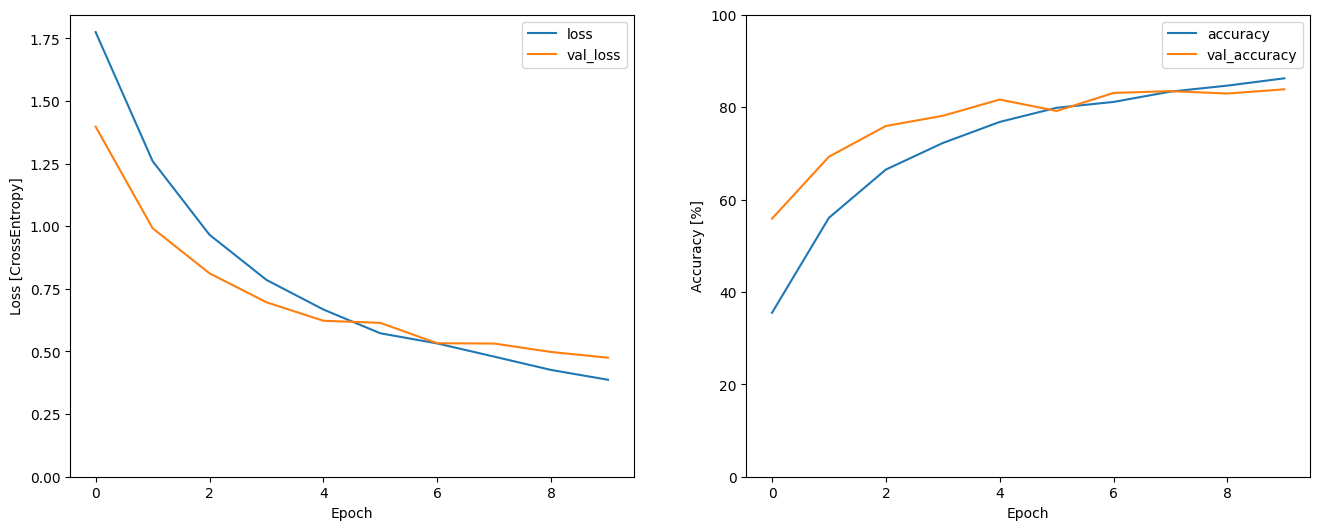

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## モデルのパフォーマンスを評価する

テストセットでモデルを実行し、モデルのパフォーマンスを確認します。

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 1/13 [=>............................] - ETA: 2s - loss: 0.4776 - accuracy: 0.7969

10/13 [======================>.......] - ETA: 0s - loss: 0.5066 - accuracy: 0.8281

13/13 [==============================] - 0s 6ms/step - loss: 0.4939 - accuracy: 0.8329


{'loss': 0.49389326572418213, 'accuracy': 0.832932710647583}

### 混同行列を表示する

<a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">混同行列</a>を使用して、モデルがテストセット内の各コマンドをどの程度うまく分類したかを確認します。


In [27]:
y_pred = model.predict(test_spectrogram_ds)

 1/13 [=>............................] - ETA: 1s

13/13 [==============================] - 0s 3ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

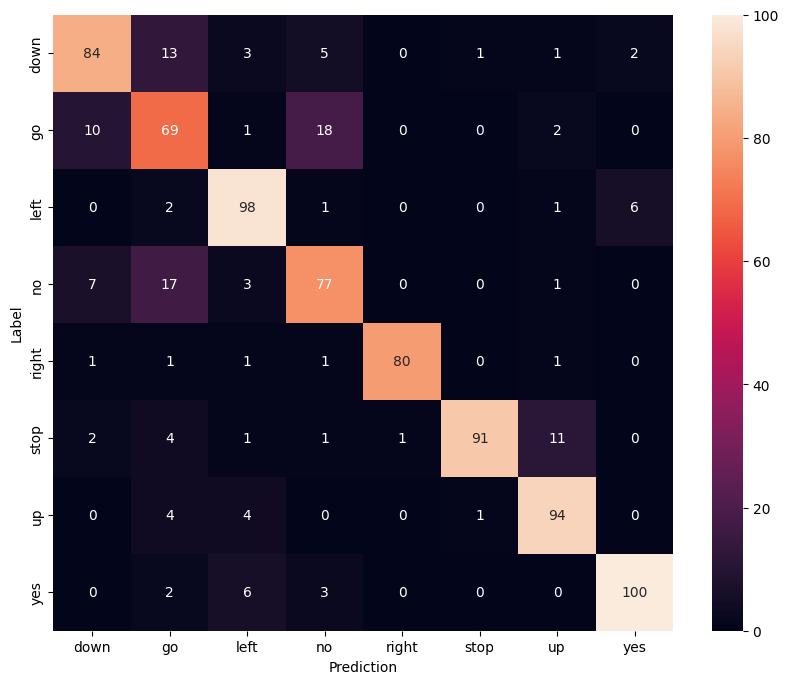

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## 音声ファイルで推論を実行する

最後に、誰かが「no」と言っている入力音声ファイルを使用して、モデルの予測出力を検証します。モデルのパフォーマンスはどうですか?

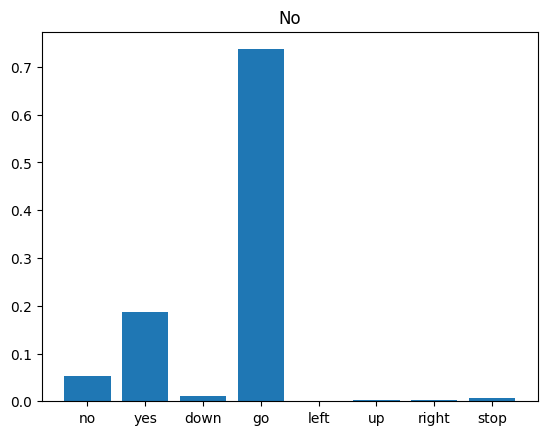

In [31]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

出力が示すように、モデルは音声コマンドを「no」として認識しているはずです。

## モデルを前処理してエクスポートする

推論のためにデータをモデルに渡す前に、これらの前処理手順を適用する必要がある場合、このモデルはあまり簡単に使用できません。そのため、エンドツーエンドのバージョンをビルドします。

In [32]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

「エクスポート」モデルをテスト実行します。

In [33]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.57496786,  1.8535713 , -0.936327  ,  3.2253902 , -4.3184023 ,
         -2.7080545 , -2.3667598 , -1.3555104 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

モデルを保存して再読み込みすると、再読み込みされたモデルから同じ出力が得られます。

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.57496786,  1.8535713 , -0.936327  ,  3.2253902 , -4.3184023 ,
         -2.7080545 , -2.3667598 , -1.3555104 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>}

## 次のステップ

このチュートリアルでは、TensorFlow と Python を使用した畳み込みニューラル ネットワークを使用して、簡単な音声分類/自動音声認識を実行する方法を実演しました。詳細については、次のリソースを参照してください。

- [YAMNet による音声分類](https://www.tensorflow.org/hub/tutorials/yamnet)のチュートリアルでは、音声分類に転移学習を使用する方法を実演します。
- <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle の TensorFlow 音声認識チャレンジ</a>のノートブック。
- <a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - 転移学習コードラボを使用した音声認識</a>では、音声分類用の独自のインタラクティブな Web アプリを構築する方法について説明します。
- <a href="https://arxiv.org/abs/1709.04396" class="external">音楽情報検索のためのディープラーニングに関するチュートリアル</a> (Choi et al., 2017)、arXiv。
- また、TensorFlow には、独自の音声ベースのプロジェクトに役立つ[音声データの準備と拡張](https://www.tensorflow.org/io/tutorials/audio)のための追加サポートがあります。
- 音楽および音声分析用の [librosa](https://librosa.org/) ライブラリの使用を検討してください。